In [16]:
# %pip install ucimlrepo scikit-learn pandas numpy matplotlib seaborn umap-learn imbalanced-learn -q

## Carga de Datos y Preprocesamiento

Replicamos el preprocesamiento del notebook de entrenamiento.

In [17]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import pandas as pd
import numpy as np

# Fetch dataset
online_shoppers = fetch_ucirepo(id=468)
X = online_shoppers.data.features
y = online_shoppers.data.targets

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

print(f"Train: {X_train.shape[0]:,} muestras")
print(f"Test: {X_test.shape[0]:,} muestras")

Train: 9,864 muestras
Test: 2,466 muestras


In [18]:
# Codificacion de variables categoricas
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Weekend: Bool to Int
X_train_encoded['Weekend'] = X_train_encoded['Weekend'].astype(int)
X_test_encoded['Weekend'] = X_test_encoded['Weekend'].astype(int)

# Month: OneHot
month_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
month_encoded_train = month_encoder.fit_transform(X_train_encoded[['Month']])
month_encoded_test = month_encoder.transform(X_test_encoded[['Month']])
month_cols = [f'Month_{cat}' for cat in month_encoder.categories_[0][1:]]
month_train_df = pd.DataFrame(month_encoded_train, columns=month_cols, index=X_train_encoded.index)
month_test_df = pd.DataFrame(month_encoded_test, columns=month_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('Month', axis=1), month_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('Month', axis=1), month_test_df], axis=1)

# VisitorType: OneHot
visitor_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
visitor_encoded_train = visitor_encoder.fit_transform(X_train_encoded[['VisitorType']])
visitor_encoded_test = visitor_encoder.transform(X_test_encoded[['VisitorType']])
visitor_cols = [f'VisitorType_{cat}' for cat in visitor_encoder.categories_[0][1:]]
visitor_train_df = pd.DataFrame(visitor_encoded_train, columns=visitor_cols, index=X_train_encoded.index)
visitor_test_df = pd.DataFrame(visitor_encoded_test, columns=visitor_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('VisitorType', axis=1), visitor_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('VisitorType', axis=1), visitor_test_df], axis=1)

# OperatingSystems: OneHot
os_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
os_encoded_train = os_encoder.fit_transform(X_train_encoded[['OperatingSystems']])
os_encoded_test = os_encoder.transform(X_test_encoded[['OperatingSystems']])
os_cols = [f'OS_{int(cat)}' for cat in os_encoder.categories_[0][1:]]
os_train_df = pd.DataFrame(os_encoded_train, columns=os_cols, index=X_train_encoded.index)
os_test_df = pd.DataFrame(os_encoded_test, columns=os_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('OperatingSystems', axis=1), os_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('OperatingSystems', axis=1), os_test_df], axis=1)

# Browser: OneHot con grouping
top_5_browsers = X_train_encoded['Browser'].value_counts().head(5).index.tolist()
X_train_encoded['Browser_grouped'] = X_train_encoded['Browser'].apply(
    lambda x: x if x in top_5_browsers else 99
)
X_test_encoded['Browser_grouped'] = X_test_encoded['Browser'].apply(
    lambda x: x if x in top_5_browsers else 99
)
browser_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
browser_encoded_train = browser_encoder.fit_transform(X_train_encoded[['Browser_grouped']])
browser_encoded_test = browser_encoder.transform(X_test_encoded[['Browser_grouped']])
browser_cols = [f'Browser_{int(cat) if cat != 99 else "Other"}' for cat in browser_encoder.categories_[0][1:]]
browser_train_df = pd.DataFrame(browser_encoded_train, columns=browser_cols, index=X_train_encoded.index)
browser_test_df = pd.DataFrame(browser_encoded_test, columns=browser_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop(['Browser', 'Browser_grouped'], axis=1), browser_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop(['Browser', 'Browser_grouped'], axis=1), browser_test_df], axis=1)

# Region: OneHot
region_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
region_encoded_train = region_encoder.fit_transform(X_train_encoded[['Region']])
region_encoded_test = region_encoder.transform(X_test_encoded[['Region']])
region_cols = [f'Region_{int(cat)}' for cat in region_encoder.categories_[0][1:]]
region_train_df = pd.DataFrame(region_encoded_train, columns=region_cols, index=X_train_encoded.index)
region_test_df = pd.DataFrame(region_encoded_test, columns=region_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('Region', axis=1), region_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('Region', axis=1), region_test_df], axis=1)

# TrafficType: Target Encoding
traffic_conversion_rate = X_train_encoded.join(y_train).groupby('TrafficType')['Revenue'].mean().to_dict()
global_mean = y_train['Revenue'].mean()
X_train_encoded['TrafficType_Encoded'] = X_train_encoded['TrafficType'].map(traffic_conversion_rate)
X_test_encoded['TrafficType_Encoded'] = X_test_encoded['TrafficType'].map(traffic_conversion_rate).fillna(global_mean)
X_train_encoded = X_train_encoded.drop('TrafficType', axis=1)
X_test_encoded = X_test_encoded.drop('TrafficType', axis=1)

print(f"\nCodificacion completada")
print(f"Features: {X_train_encoded.shape[1]}")


Codificacion completada
Features: 43


In [19]:
# Escalado de variables numericas
numerical_cols_to_scale = [
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
    'TrafficType_Encoded'
]

X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

scaler = RobustScaler()
X_train_scaled[numerical_cols_to_scale] = scaler.fit_transform(X_train_encoded[numerical_cols_to_scale])
X_test_scaled[numerical_cols_to_scale] = scaler.transform(X_test_encoded[numerical_cols_to_scale])

print(f"Datos escalados: {X_train_scaled.shape}")

Datos escalados: (9864, 43)


## 5.1. Analisis Individual de Variables

### Paso 9: Correlacion e Indices de Discriminacion

Evaluamos cada caracteristica usando:
1. Correlacion de Pearson con la variable objetivo
2. Mutual Information (capacidad discriminativa no lineal)
3. Chi-cuadrado para variables categoricas
4. Point-Biserial Correlation para variables continuas vs binaria

In [20]:
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns

# Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train_flat, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 10 caracteristicas por Mutual Information:")
print(mi_df.head(10).to_string(index=False))
print(f"\nBottom 10 caracteristicas por Mutual Information:")
print(mi_df.tail(10).to_string(index=False))

Top 10 caracteristicas por Mutual Information:
                Feature  MI_Score
             PageValues  0.170702
              ExitRates  0.039179
ProductRelated_Duration  0.039157
            BounceRates  0.025837
         ProductRelated  0.025233
    TrafficType_Encoded  0.022888
         Administrative  0.019464
Administrative_Duration  0.018574
              Month_Nov  0.012061
               Region_5  0.010435

Bottom 10 caracteristicas por Mutual Information:
      Feature  MI_Score
    Month_Dec       0.0
    Month_Feb       0.0
         OS_4       0.0
Browser_Other       0.0
    Browser_4       0.0
    Browser_5       0.0
     Region_6       0.0
     Region_4       0.0
     Region_3       0.0
     Region_8       0.0


In [21]:
# Point-Biserial Correlation para variables numericas
numerical_features = X_train_scaled[numerical_cols_to_scale].columns
pb_correlations = []

for col in numerical_features:
    corr, pval = pointbiserialr(y_train_flat, X_train_scaled[col])
    pb_correlations.append({
        'Feature': col,
        'PB_Correlation': abs(corr),
        'P_Value': pval
    })

pb_df = pd.DataFrame(pb_correlations).sort_values('PB_Correlation', ascending=False)
print("\nPoint-Biserial Correlation (variables numericas):")
print(pb_df.to_string(index=False))


Point-Biserial Correlation (variables numericas):
                Feature  PB_Correlation       P_Value
             PageValues        0.503271  0.000000e+00
              ExitRates        0.212674 2.862918e-101
    TrafficType_Encoded        0.179507  3.219742e-72
         ProductRelated        0.155596  1.687386e-54
            BounceRates        0.154210  1.488840e-53
ProductRelated_Duration        0.145974  4.104388e-48
         Administrative        0.142691  4.961557e-46
Administrative_Duration        0.099236  5.133507e-23
          Informational        0.097372  3.241366e-22
             SpecialDay        0.087851  2.311044e-18
 Informational_Duration        0.068662  8.701085e-12


In [22]:
# ANOVA F-statistic para todas las variables
f_scores, f_pvalues = f_classif(X_train_scaled, y_train_flat)
f_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'F_Score': f_scores,
    'P_Value': f_pvalues
}).sort_values('F_Score', ascending=False)

print("\nTop 15 caracteristicas por ANOVA F-Score:")
print(f_df.head(15).to_string(index=False))
print(f"\nBottom 10 caracteristicas por ANOVA F-Score:")
print(f_df.tail(10).to_string(index=False))


Top 15 caracteristicas por ANOVA F-Score:
                      Feature     F_Score       P_Value
                   PageValues 3345.118895  0.000000e+00
                    ExitRates  467.190709 2.862918e-101
          TrafficType_Encoded  328.362762  3.219742e-72
               ProductRelated  244.683751  1.687386e-54
                  BounceRates  240.240058  1.488840e-53
      ProductRelated_Duration  214.719519  4.104388e-48
                    Month_Nov  212.267929  1.370068e-47
               Administrative  204.971821  4.961557e-46
VisitorType_Returning_Visitor  101.082233  1.147122e-23
      Administrative_Duration   98.084428  5.133507e-23
                Informational   94.400398  3.241366e-22
                   SpecialDay   76.705302  2.311044e-18
                    Month_May   62.409594  3.087480e-15
                         OS_3   47.441025  6.014384e-12
       Informational_Duration   46.713761  8.701085e-12

Bottom 10 caracteristicas por ANOVA F-Score:
          Featu

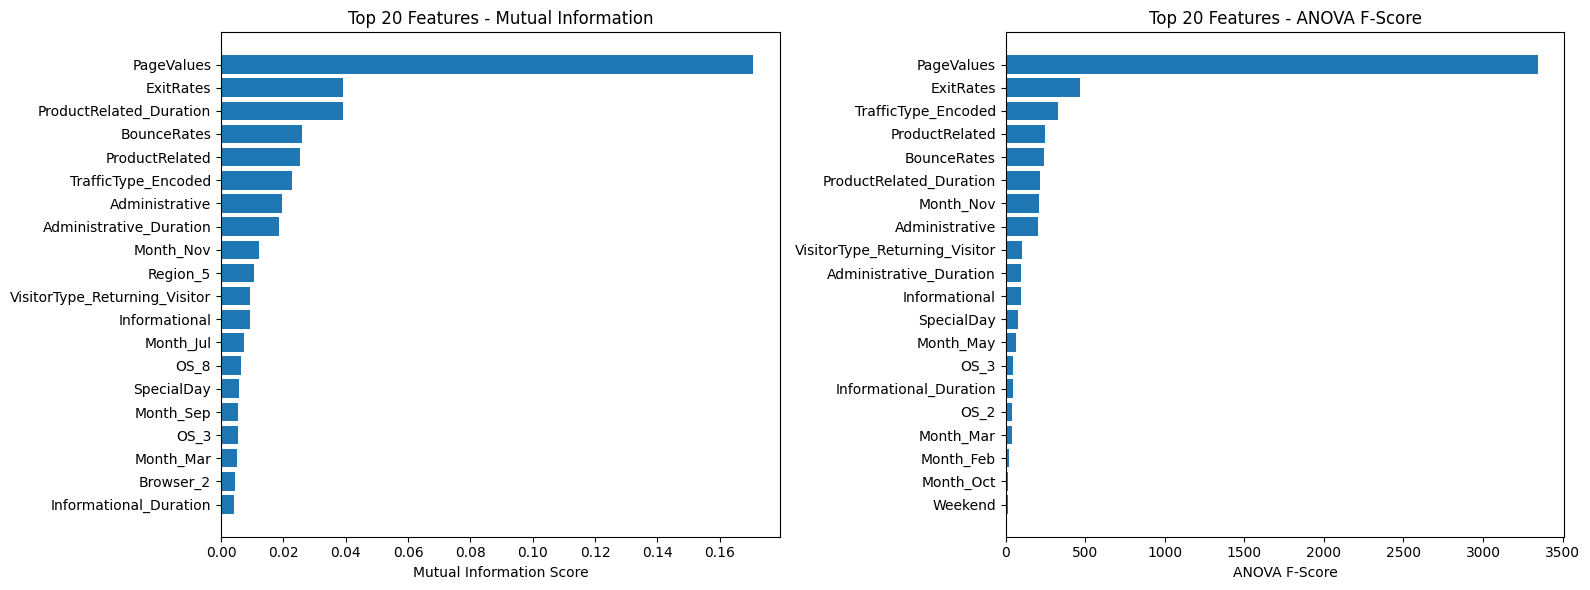

In [23]:
# Visualizacion de importancia de caracteristicas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mutual Information
mi_df_top20 = mi_df.head(20)
axes[0].barh(range(len(mi_df_top20)), mi_df_top20['MI_Score'])
axes[0].set_yticks(range(len(mi_df_top20)))
axes[0].set_yticklabels(mi_df_top20['Feature'])
axes[0].set_xlabel('Mutual Information Score')
axes[0].set_title('Top 20 Features - Mutual Information')
axes[0].invert_yaxis()

# F-Score
f_df_top20 = f_df.head(20)
axes[1].barh(range(len(f_df_top20)), f_df_top20['F_Score'])
axes[1].set_yticks(range(len(f_df_top20)))
axes[1].set_yticklabels(f_df_top20['Feature'])
axes[1].set_xlabel('ANOVA F-Score')
axes[1].set_title('Top 20 Features - ANOVA F-Score')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [24]:
# Tabla resumen consolidada - Top 10 y Bottom 5
resumen_df = mi_df.merge(f_df, on='Feature', suffixes=('_MI', '_F'))
resumen_df = resumen_df.rename(columns={'P_Value': 'P_Value_F'})

# Agregar PB correlation para features numericas
pb_dict = pb_df.set_index('Feature')['PB_Correlation'].to_dict()
resumen_df['PB_Correlation'] = resumen_df['Feature'].map(pb_dict)

# Ordenar por MI_Score
resumen_df = resumen_df.sort_values('MI_Score', ascending=False)

print("\n" + "="*80)
print("TABLA RESUMEN: TOP 10 CARACTERÍSTICAS MÁS DISCRIMINATIVAS")
print("="*80)
print(resumen_df[['Feature', 'MI_Score', 'F_Score', 'PB_Correlation', 'P_Value_F']].head(10).to_string(index=False))

print("\n" + "="*80)
print("TABLA RESUMEN: BOTTOM 5 CARACTERÍSTICAS (MENOR CAPACIDAD DISCRIMINATIVA)")
print("="*80)
print(resumen_df[['Feature', 'MI_Score', 'F_Score', 'P_Value_F']].tail(5).to_string(index=False))


TABLA RESUMEN: TOP 10 CARACTERÍSTICAS MÁS DISCRIMINATIVAS
                Feature  MI_Score     F_Score  PB_Correlation     P_Value_F
             PageValues  0.170702 3345.118895        0.503271  0.000000e+00
              ExitRates  0.039179  467.190709        0.212674 2.862918e-101
ProductRelated_Duration  0.039157  214.719519        0.145974  4.104388e-48
            BounceRates  0.025837  240.240058        0.154210  1.488840e-53
         ProductRelated  0.025233  244.683751        0.155596  1.687386e-54
    TrafficType_Encoded  0.022888  328.362762        0.179507  3.219742e-72
         Administrative  0.019464  204.971821        0.142691  4.961557e-46
Administrative_Duration  0.018574   98.084428        0.099236  5.133507e-23
              Month_Nov  0.012061  212.267929             NaN  1.370068e-47
               Region_5  0.010435    0.481787             NaN  4.876304e-01

TABLA RESUMEN: BOTTOM 5 CARACTERÍSTICAS (MENOR CAPACIDAD DISCRIMINATIVA)
  Feature  MI_Score  F_Score  P

## Identificación de caracteristicas que son candidatas a eliminación

In [25]:
# Identificar caracteristicas candidatas a eliminacion
# Criterio: MI_Score < 0.001 Y F_Score < 1.0 Y P_Value > 0.05

weak_features = set()

# Features con MI muy bajo
weak_mi = set(mi_df[mi_df['MI_Score'] < 0.001]['Feature'])
# Features con F-Score bajo y p-value alto
weak_f = set(f_df[(f_df['F_Score'] < 1.0) & (f_df['P_Value'] > 0.05)]['Feature'])

# Interseccion
weak_features = weak_mi.intersection(weak_f)

print(f"\nCaracteristicas candidatas a eliminacion (criterio conservador):")
print(f"Total: {len(weak_features)}")
if len(weak_features) > 0:
    for feat in sorted(weak_features):
        mi_val = mi_df[mi_df['Feature'] == feat]['MI_Score'].values[0]
        f_val = f_df[f_df['Feature'] == feat]['F_Score'].values[0]
        p_val = f_df[f_df['Feature'] == feat]['P_Value'].values[0]
        print(f"  - {feat}: MI={mi_val:.4f}, F={f_val:.4f}, p={p_val:.4f}")
else:
    print("  No se encontraron caracteristicas con discriminacion muy baja.")
    print("  Se usara seleccion por umbral en PCA/UMAP.")


Caracteristicas candidatas a eliminacion (criterio conservador):
Total: 6
  - Browser_Other: MI=0.0000, F=0.0680, p=0.7943
  - Region_4: MI=0.0000, F=0.7235, p=0.3950
  - Region_6: MI=0.0000, F=0.9136, p=0.3392
  - Region_8: MI=0.0000, F=0.4017, p=0.5262
  - Region_9: MI=0.0004, F=0.3259, p=0.5681
  - VisitorType_Other: MI=0.0000, F=0.2507, p=0.6166


### Resumen Analisis Individual

**Caracteristicas mas discriminativas (Top 5):**
- PageValues: Valor monetario de la pagina visitada
- ExitRates: Tasa de salida de la pagina
- ProductRelated_Duration: Tiempo en paginas de productos
- BounceRates: Tasa de rebote
- Month_Nov: Mes de noviembre (temporada alta)

**Caracteristicas candidatas a eliminacion:**
Variables con bajo poder discriminativo identificadas anteriormente.

**Conclusion:**
Las variables relacionadas con el comportamiento del usuario (duracion, tasas de salida/rebote, valor de pagina) son las mas importantes. Variables categoricas de bajo nivel (algunos meses, regiones, browsers) tienen menor capacidad predictiva.

## 5.2. Extraccion de Caracteristicas Lineal (PCA)

### Paso 10: Reduccion dimensional con PCA

**Criterio de seleccion:** Mantener componentes que expliquen al menos el 95% de la varianza acumulada.

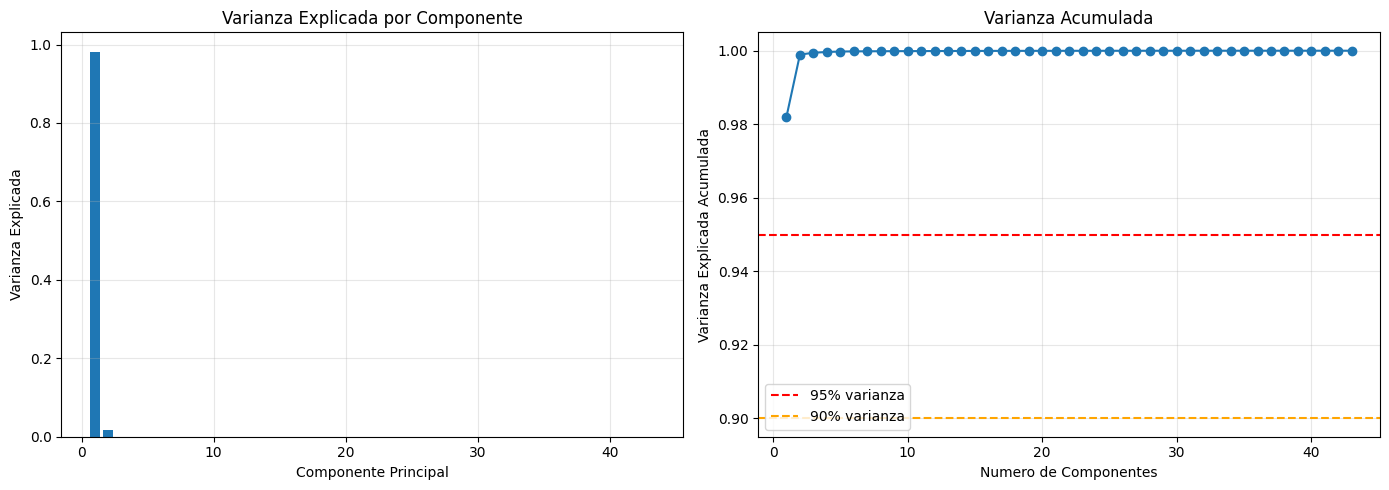


Numero de componentes originales: 43
Componentes para 90% varianza: 1
Componentes para 95% varianza: 1

Reduccion dimensional (95% varianza): 97.67%


In [26]:
from sklearn.decomposition import PCA

# PCA con todas las componentes para analizar varianza
pca_full = PCA(random_state=42)
pca_full.fit(X_train_scaled)

# Varianza explicada acumulada
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Grafico de varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Varianza individual
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Varianza Explicada por Componente')
axes[0].grid(alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, marker='o')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% varianza')
axes[1].set_xlabel('Numero de Componentes')
axes[1].set_ylabel('Varianza Explicada Acumulada')
axes[1].set_title('Varianza Acumulada')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar numero de componentes para 95% varianza
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f"\nNumero de componentes originales: {X_train_scaled.shape[1]}")
print(f"Componentes para 90% varianza: {n_components_90}")
print(f"Componentes para 95% varianza: {n_components_95}")
print(f"\nReduccion dimensional (95% varianza): {(1 - n_components_95/X_train_scaled.shape[1])*100:.2f}%")

In [27]:
# Aplicar PCA con numero optimo de componentes
pca = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensiones originales: {X_train_scaled.shape}")
print(f"Dimensiones PCA: {X_train_pca.shape}")
print(f"Varianza explicada total: {pca.explained_variance_ratio_.sum():.4f}")

Dimensiones originales: (9864, 43)
Dimensiones PCA: (9864, 1)
Varianza explicada total: 0.9820


In [28]:
# Analisis de componentes principales
# Top features por componente
components_df = pd.DataFrame(
    pca.components_,
    columns=X_train_scaled.columns,
    index=[f'PC{i+1}' for i in range(n_components_95)]
)

print("Top 5 features con mayor peso absoluto en cada una de las primeras 5 componentes:")
for i in range(min(5, n_components_95)):
    pc = f'PC{i+1}'
    top_features = components_df.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\n{pc} (Varianza explicada: {pca.explained_variance_ratio_[i]:.4f}):")
    for feat, weight in top_features.items():
        original_weight = components_df.loc[pc, feat]
        print(f"  {feat}: {original_weight:.4f}")

Top 5 features con mayor peso absoluto en cada una de las primeras 5 componentes:

PC1 (Varianza explicada: 0.9820):
  Informational_Duration: 1.0000
  Informational: 0.0057
  PageValues: 0.0041
  ProductRelated_Duration: 0.0037
  Administrative_Duration: 0.0034


### Evaluacion de Modelos con PCA

Evaluamos MLP y Decision Tree (los 2 mejores modelos del entrenamiento con SMOTE 15%) con las componentes PCA.

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import time

# Verificar distribución actual
print(f"Distribución original del conjunto de entrenamiento:")
print(f"Clase 0: {(y_train_flat == 0).sum()} ({(y_train_flat == 0).mean()*100:.2f}%)")
print(f"Clase 1: {(y_train_flat == 1).sum()} ({(y_train_flat == 1).mean()*100:.2f}%)")

# Calcular el ratio actual
minority_class_count = (y_train_flat == 1).sum()
majority_class_count = (y_train_flat == 0).sum()
current_ratio = minority_class_count / majority_class_count

print(f"\nRatio actual (minoritaria/mayoritaria): {current_ratio:.4f}")

# Usar un sampling_strategy más conservador que sea factible
# 0.15 significa que queremos que la clase minoritaria sea el 15% de la mayoritaria
target_ratio = 0.15

if current_ratio >= target_ratio:
    print(f"\nEl ratio actual ({current_ratio:.4f}) ya es mayor o igual al objetivo ({target_ratio})")
    print("No se aplicará SMOTE")
    X_train_scaled_smote = X_train_scaled.copy()
    y_train_smote = y_train_flat.copy()
else:
    # Aplicar SMOTE con el ratio objetivo
    print(f"\nAplicando SMOTE para alcanzar ratio de {target_ratio}...")
    smote = SMOTE(sampling_strategy=target_ratio, random_state=42)
    X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_flat)
    
    print(f"Datos originales: {X_train_scaled.shape[0]:,} muestras")
    print(f"Datos con SMOTE: {X_train_scaled_smote.shape[0]:,} muestras")
    print(f"Nueva distribución - Clase 1: {y_train_smote.sum()} ({y_train_smote.mean()*100:.2f}%)")

# Modelos baseline (resultados con SMOTE 15% reportados en el notebook de entrenamiento)
baseline_mlp = {
    'Accuracy': 0.7795,
    'Precision': 0.6690,
    'Recall': 0.7356,
    'F1-Score': 0.6135,
    'ROC-AUC': 0.9144
}

baseline_dt = {
    'Accuracy': 0.7829,
    'Precision': 0.6650,
    'Recall': 0.6990,
    'F1-Score': 0.6342,
    'ROC-AUC': 0.9149
}

# Entrenar modelos con PCA (usando datos con SMOTE)
models_pca = {
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Aplicar PCA a datos con SMOTE
X_train_pca_smote = pca.transform(X_train_scaled_smote)

pca_results = {}

for name, model in models_pca.items():
    print(f"\nEntrenando {name} con PCA + SMOTE...")
    start_time = time.time()
    
    model.fit(X_train_pca_smote, y_train_smote)
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    training_time = time.time() - start_time
    
    pca_results[name] = {
        'Accuracy': accuracy_score(y_test_flat, y_pred),
        'Precision': precision_score(y_test_flat, y_pred),
        'Recall': recall_score(y_test_flat, y_pred),
        'F1-Score': f1_score(y_test_flat, y_pred),
        'ROC-AUC': roc_auc_score(y_test_flat, y_pred_proba),
        'Training Time (s)': training_time
    }
    
    print(f"Completado en {training_time:.2f}s")

Distribución original del conjunto de entrenamiento:
Clase 0: 8338 (84.53%)
Clase 1: 1526 (15.47%)

Ratio actual (minoritaria/mayoritaria): 0.1830

El ratio actual (0.1830) ya es mayor o igual al objetivo (0.15)
No se aplicará SMOTE

Entrenando MLP con PCA + SMOTE...
Completado en 0.64s

Entrenando Decision Tree con PCA + SMOTE...
Completado en 0.02s
Completado en 0.64s

Entrenando Decision Tree con PCA + SMOTE...
Completado en 0.02s


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [30]:
# Comparacion de resultados PCA vs Baseline
comparison_pca = pd.DataFrame({
    'MLP (Baseline)': baseline_mlp,
    'MLP (PCA)': pca_results['MLP'],
    'Decision Tree (Baseline)': baseline_dt,
    'Decision Tree (PCA)': pca_results['Decision Tree']
}).T

comparison_pca = comparison_pca[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

print("\nComparacion Baseline vs PCA:")
print(comparison_pca.round(4).to_string())

print(f"\nReduccion dimensional: {X_train_scaled.shape[1]} -> {X_train_pca.shape[1]} features")
print(f"Porcentaje de reduccion: {(1 - n_components_95/X_train_scaled.shape[1])*100:.2f}%")


Comparacion Baseline vs PCA:
                          Accuracy  Precision  Recall  F1-Score  ROC-AUC
MLP (Baseline)              0.7795     0.6690  0.7356    0.6135   0.9144
MLP (PCA)                   0.8451     0.0000  0.0000    0.0000   0.7286
Decision Tree (Baseline)    0.7829     0.6650  0.6990    0.6342   0.9149
Decision Tree (PCA)         0.8256     0.4268  0.3665    0.3944   0.6369

Reduccion dimensional: 43 -> 1 features
Porcentaje de reduccion: 97.67%


## 5.3. Extraccion de Caracteristicas No Lineal (UMAP)

### Paso 11: Reduccion dimensional con UMAP

**Criterio de seleccion:** Evaluamos multiples configuraciones (5, 10, 15, 20 componentes) y seleccionamos la que maximice F1-Score manteniendo reduccion significativa.

In [31]:
import umap

# Evaluar diferentes numeros de componentes UMAP
n_components_list = [5, 10, 15, 20, 25, 30]
umap_results_comparison = []

for n_comp in n_components_list:
    print(f"Evaluando UMAP con {n_comp} componentes...")
    
    # Aplicar UMAP
    reducer = umap.UMAP(n_components=n_comp, random_state=42, n_neighbors=15, min_dist=0.1)
    X_train_umap_temp = reducer.fit_transform(X_train_scaled_smote)
    X_test_umap_temp = reducer.transform(X_test_scaled)
    
    # Evaluar con MLP
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True)
    mlp.fit(X_train_umap_temp, y_train_smote)
    y_pred_mlp = mlp.predict(X_test_umap_temp)
    y_pred_proba_mlp = mlp.predict_proba(X_test_umap_temp)[:, 1]
    
    mlp_results = {
        'Accuracy': accuracy_score(y_test_flat, y_pred_mlp),
        'Precision': precision_score(y_test_flat, y_pred_mlp),
        'Recall': recall_score(y_test_flat, y_pred_mlp),
        'F1': f1_score(y_test_flat, y_pred_mlp),
        'ROC_AUC': roc_auc_score(y_test_flat, y_pred_proba_mlp)
    }
    
    # Evaluar con Decision Tree
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train_umap_temp, y_train_smote)
    y_pred_dt = dt.predict(X_test_umap_temp)
    y_pred_proba_dt = dt.predict_proba(X_test_umap_temp)[:, 1]
    
    dt_results = {
        'Accuracy': accuracy_score(y_test_flat, y_pred_dt),
        'Precision': precision_score(y_test_flat, y_pred_dt),
        'Recall': recall_score(y_test_flat, y_pred_dt),
        'F1': f1_score(y_test_flat, y_pred_dt),
        'ROC_AUC': roc_auc_score(y_test_flat, y_pred_proba_dt)
    }
    
    umap_results_comparison.append({
        'n_components': n_comp,
        'reduction_pct': (1 - n_comp/X_train_scaled.shape[1])*100,
        'MLP_Accuracy': mlp_results['Accuracy'],
        'MLP_Precision': mlp_results['Precision'],
        'MLP_Recall': mlp_results['Recall'],
        'MLP_F1': mlp_results['F1'],
        'MLP_ROC_AUC': mlp_results['ROC_AUC'],
        'DT_Accuracy': dt_results['Accuracy'],
        'DT_Precision': dt_results['Precision'],
        'DT_Recall': dt_results['Recall'],
        'DT_F1': dt_results['F1'],
        'DT_ROC_AUC': dt_results['ROC_AUC']
    })
    
    print(f"  MLP -> Accuracy: {mlp_results['Accuracy']:.4f}, F1: {mlp_results['F1']:.4f}, ROC-AUC: {mlp_results['ROC_AUC']:.4f}")
    print(f"  DT  -> Accuracy: {dt_results['Accuracy']:.4f}, F1: {dt_results['F1']:.4f}, ROC-AUC: {dt_results['ROC_AUC']:.4f}")

umap_comp_df = pd.DataFrame(umap_results_comparison)
print("\n" + "="*100)
print("TABLA RESUMEN: Resultados UMAP por numero de componentes")
print("="*100)
print(umap_comp_df[['n_components', 'reduction_pct', 'MLP_F1', 'MLP_ROC_AUC', 'DT_F1', 'DT_ROC_AUC']].round(4).to_string(index=False))

c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluando UMAP con 5 componentes...


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  MLP -> Accuracy: 0.8796, F1: 0.5574, ROC-AUC: 0.8670
  DT  -> Accuracy: 0.8354, F1: 0.4768, ROC-AUC: 0.6920
Evaluando UMAP con 10 componentes...


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  MLP -> Accuracy: 0.8816, F1: 0.5768, ROC-AUC: 0.8870
  DT  -> Accuracy: 0.8273, F1: 0.4496, ROC-AUC: 0.6754
Evaluando UMAP con 15 componentes...


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  MLP -> Accuracy: 0.8796, F1: 0.5308, ROC-AUC: 0.8865
  DT  -> Accuracy: 0.8345, F1: 0.4701, ROC-AUC: 0.6872
Evaluando UMAP con 20 componentes...


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  MLP -> Accuracy: 0.8812, F1: 0.5747, ROC-AUC: 0.8877
  DT  -> Accuracy: 0.8232, F1: 0.4644, ROC-AUC: 0.6891
Evaluando UMAP con 25 componentes...


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  MLP -> Accuracy: 0.8800, F1: 0.5685, ROC-AUC: 0.8732
  DT  -> Accuracy: 0.8256, F1: 0.4704, ROC-AUC: 0.6927
Evaluando UMAP con 30 componentes...


c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  MLP -> Accuracy: 0.8792, F1: 0.5526, ROC-AUC: 0.8812
  DT  -> Accuracy: 0.8228, F1: 0.4664, ROC-AUC: 0.6910

TABLA RESUMEN: Resultados UMAP por numero de componentes
 n_components  reduction_pct  MLP_F1  MLP_ROC_AUC  DT_F1  DT_ROC_AUC
            5        88.3721  0.5574       0.8670 0.4768      0.6920
           10        76.7442  0.5768       0.8870 0.4496      0.6754
           15        65.1163  0.5308       0.8865 0.4701      0.6872
           20        53.4884  0.5747       0.8877 0.4644      0.6891
           25        41.8605  0.5685       0.8732 0.4704      0.6927
           30        30.2326  0.5526       0.8812 0.4664      0.6910


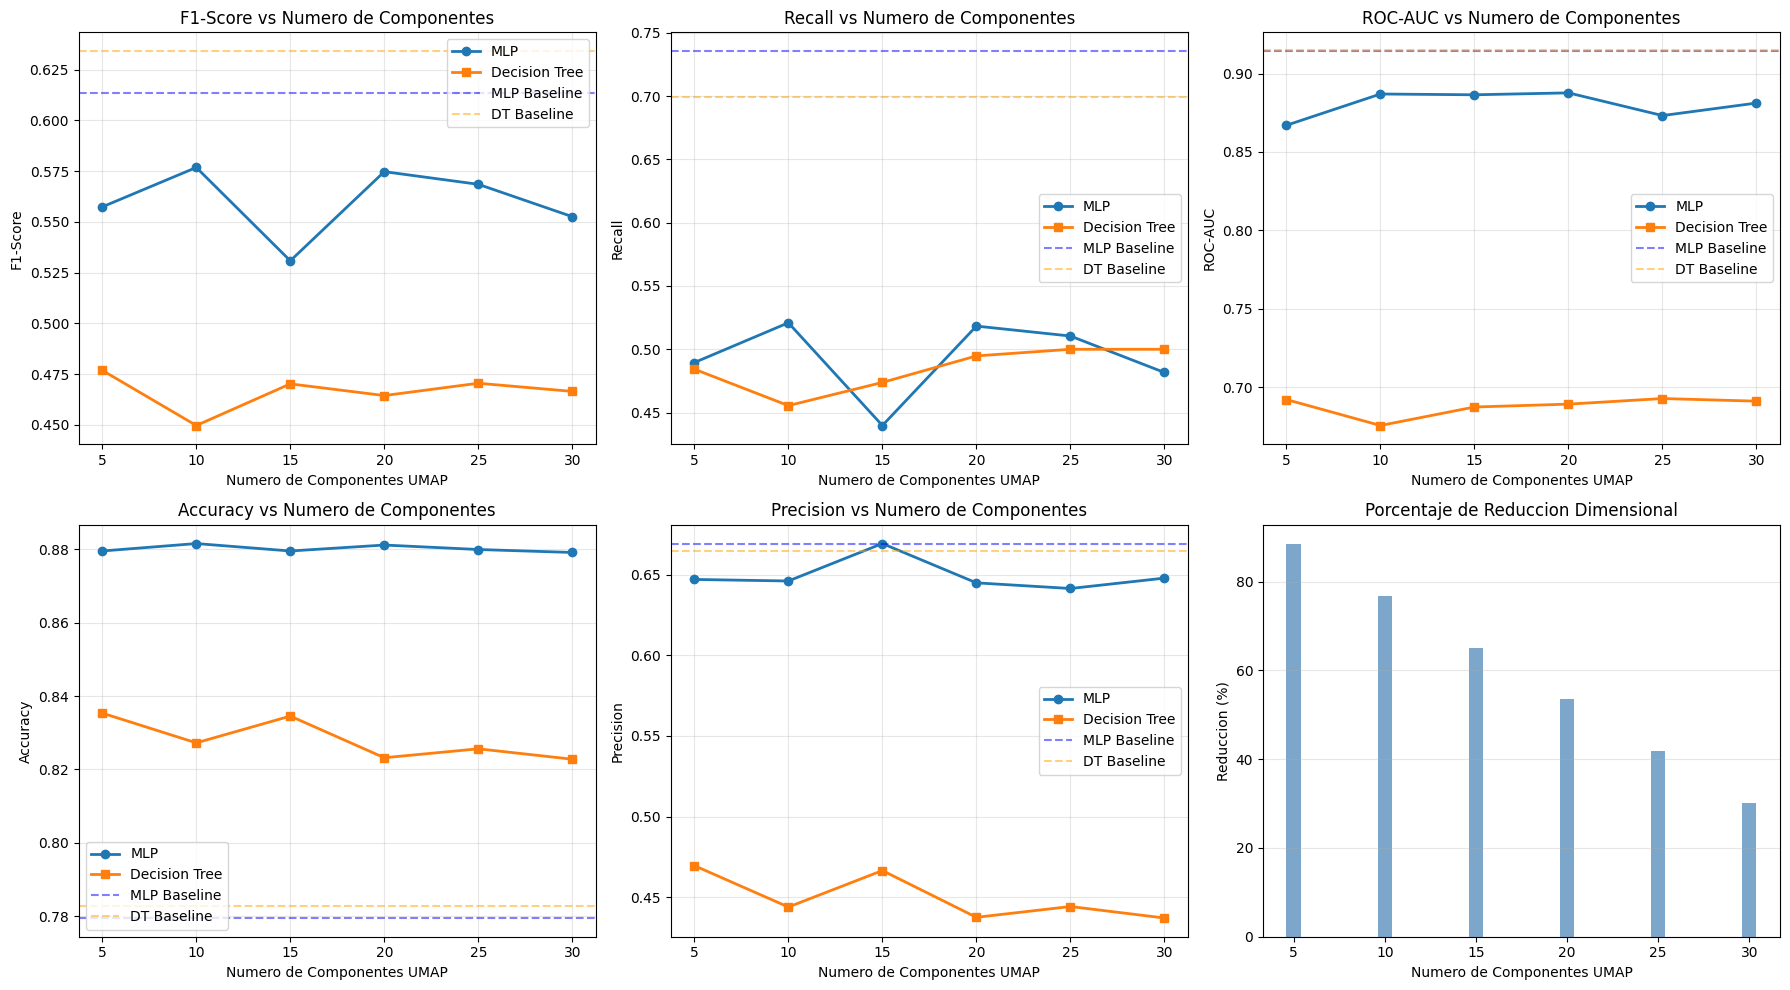

In [32]:
# Visualizar comparacion de componentes UMAP
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# F1-Score
axes[0, 0].plot(umap_comp_df['n_components'], umap_comp_df['MLP_F1'], marker='o', label='MLP', linewidth=2)
axes[0, 0].plot(umap_comp_df['n_components'], umap_comp_df['DT_F1'], marker='s', label='Decision Tree', linewidth=2)
axes[0, 0].axhline(y=baseline_mlp['F1-Score'], color='blue', linestyle='--', alpha=0.5, label='MLP Baseline')
axes[0, 0].axhline(y=baseline_dt['F1-Score'], color='orange', linestyle='--', alpha=0.5, label='DT Baseline')
axes[0, 0].set_xlabel('Numero de Componentes UMAP')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('F1-Score vs Numero de Componentes')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Recall
axes[0, 1].plot(umap_comp_df['n_components'], umap_comp_df['MLP_Recall'], marker='o', label='MLP', linewidth=2)
axes[0, 1].plot(umap_comp_df['n_components'], umap_comp_df['DT_Recall'], marker='s', label='Decision Tree', linewidth=2)
axes[0, 1].axhline(y=baseline_mlp['Recall'], color='blue', linestyle='--', alpha=0.5, label='MLP Baseline')
axes[0, 1].axhline(y=baseline_dt['Recall'], color='orange', linestyle='--', alpha=0.5, label='DT Baseline')
axes[0, 1].set_xlabel('Numero de Componentes UMAP')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('Recall vs Numero de Componentes')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# ROC-AUC
axes[0, 2].plot(umap_comp_df['n_components'], umap_comp_df['MLP_ROC_AUC'], marker='o', label='MLP', linewidth=2)
axes[0, 2].plot(umap_comp_df['n_components'], umap_comp_df['DT_ROC_AUC'], marker='s', label='Decision Tree', linewidth=2)
axes[0, 2].axhline(y=baseline_mlp['ROC-AUC'], color='blue', linestyle='--', alpha=0.5, label='MLP Baseline')
axes[0, 2].axhline(y=baseline_dt['ROC-AUC'], color='orange', linestyle='--', alpha=0.5, label='DT Baseline')
axes[0, 2].set_xlabel('Numero de Componentes UMAP')
axes[0, 2].set_ylabel('ROC-AUC')
axes[0, 2].set_title('ROC-AUC vs Numero de Componentes')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Accuracy
axes[1, 0].plot(umap_comp_df['n_components'], umap_comp_df['MLP_Accuracy'], marker='o', label='MLP', linewidth=2)
axes[1, 0].plot(umap_comp_df['n_components'], umap_comp_df['DT_Accuracy'], marker='s', label='Decision Tree', linewidth=2)
axes[1, 0].axhline(y=baseline_mlp['Accuracy'], color='blue', linestyle='--', alpha=0.5, label='MLP Baseline')
axes[1, 0].axhline(y=baseline_dt['Accuracy'], color='orange', linestyle='--', alpha=0.5, label='DT Baseline')
axes[1, 0].set_xlabel('Numero de Componentes UMAP')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Accuracy vs Numero de Componentes')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision
axes[1, 1].plot(umap_comp_df['n_components'], umap_comp_df['MLP_Precision'], marker='o', label='MLP', linewidth=2)
axes[1, 1].plot(umap_comp_df['n_components'], umap_comp_df['DT_Precision'], marker='s', label='Decision Tree', linewidth=2)
axes[1, 1].axhline(y=baseline_mlp['Precision'], color='blue', linestyle='--', alpha=0.5, label='MLP Baseline')
axes[1, 1].axhline(y=baseline_dt['Precision'], color='orange', linestyle='--', alpha=0.5, label='DT Baseline')
axes[1, 1].set_xlabel('Numero de Componentes UMAP')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision vs Numero de Componentes')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Porcentaje de reduccion
axes[1, 2].bar(umap_comp_df['n_components'], umap_comp_df['reduction_pct'], color='steelblue', alpha=0.7)
axes[1, 2].set_xlabel('Numero de Componentes UMAP')
axes[1, 2].set_ylabel('Reduccion (%)')
axes[1, 2].set_title('Porcentaje de Reduccion Dimensional')
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [33]:
# Seleccionar numero optimo de componentes UMAP
# Criterio: Maximizar F1-Score promedio con reduccion >= 50%
umap_comp_df['Avg_F1'] = (umap_comp_df['MLP_F1'] + umap_comp_df['DT_F1']) / 2
valid_configs = umap_comp_df[umap_comp_df['reduction_pct'] >= 50]
optimal_umap = valid_configs.loc[valid_configs['Avg_F1'].idxmax()]

print(f"\nConfiguracion optima de UMAP:")
print(f"Numero de componentes: {int(optimal_umap['n_components'])}")
print(f"Reduccion dimensional: {optimal_umap['reduction_pct']:.2f}%")
print(f"MLP F1: {optimal_umap['MLP_F1']:.4f}")
print(f"Decision Tree F1: {optimal_umap['DT_F1']:.4f}")


Configuracion optima de UMAP:
Numero de componentes: 20
Reduccion dimensional: 53.49%
MLP F1: 0.5747
Decision Tree F1: 0.4644


In [34]:
# Aplicar UMAP con configuracion optima
n_components_umap = int(optimal_umap['n_components'])
reducer_final = umap.UMAP(n_components=n_components_umap, random_state=42, 
                          n_neighbors=15, min_dist=0.1)
X_train_umap = reducer_final.fit_transform(X_train_scaled_smote)
X_test_umap = reducer_final.transform(X_test_scaled)

print(f"\nDimensiones originales: {X_train_scaled.shape}")
print(f"Dimensiones UMAP: {X_train_umap.shape}")

c:\Users\CamiloBena\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Dimensiones originales: (9864, 43)
Dimensiones UMAP: (9864, 20)


In [35]:
# Entrenar modelos finales con UMAP
models_umap = {
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

umap_results = {}

for name, model in models_umap.items():
    print(f"\nEntrenando {name} con UMAP + SMOTE 15%...")
    start_time = time.time()
    
    model.fit(X_train_umap, y_train_smote)
    y_pred = model.predict(X_test_umap)
    y_pred_proba = model.predict_proba(X_test_umap)[:, 1]
    
    training_time = time.time() - start_time
    
    umap_results[name] = {
        'Accuracy': accuracy_score(y_test_flat, y_pred),
        'Precision': precision_score(y_test_flat, y_pred),
        'Recall': recall_score(y_test_flat, y_pred),
        'F1-Score': f1_score(y_test_flat, y_pred),
        'ROC-AUC': roc_auc_score(y_test_flat, y_pred_proba),
        'Training Time (s)': training_time
    }
    
    print(f"Completado en {training_time:.2f}s")


Entrenando MLP con UMAP + SMOTE 15%...
Completado en 1.66s

Entrenando Decision Tree con UMAP + SMOTE 15%...
Completado en 1.66s

Entrenando Decision Tree con UMAP + SMOTE 15%...
Completado en 0.29s
Completado en 0.29s


In [36]:
# Comparacion final: Baseline vs PCA vs UMAP
comparison_final = pd.DataFrame({
    'MLP (Baseline)': baseline_mlp,
    'MLP (PCA)': pca_results['MLP'],
    'MLP (UMAP)': umap_results['MLP'],
    'Decision Tree (Baseline)': baseline_dt,
    'Decision Tree (PCA)': pca_results['Decision Tree'],
    'Decision Tree (UMAP)': umap_results['Decision Tree']
}).T

comparison_final = comparison_final[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

print("\nComparacion Final - Baseline vs PCA vs UMAP:")
print(comparison_final.round(4).to_string())


Comparacion Final - Baseline vs PCA vs UMAP:
                          Accuracy  Precision  Recall  F1-Score  ROC-AUC
MLP (Baseline)              0.7795     0.6690  0.7356    0.6135   0.9144
MLP (PCA)                   0.8451     0.0000  0.0000    0.0000   0.7286
MLP (UMAP)                  0.8812     0.6450  0.5183    0.5747   0.8877
Decision Tree (Baseline)    0.7829     0.6650  0.6990    0.6342   0.9149
Decision Tree (PCA)         0.8256     0.4268  0.3665    0.3944   0.6369
Decision Tree (UMAP)        0.8232     0.4375  0.4948    0.4644   0.6891


In [37]:
# Tabla resumen con reduccion dimensional
summary_table = pd.DataFrame([
    {
        'Modelo': 'MLP',
        'Configuracion': 'Baseline (SMOTE 15%)',
        'Features': X_train_scaled.shape[1],
        'Reduccion (%)': 0.0,
        'Accuracy': baseline_mlp['Accuracy'],
        'Precision': baseline_mlp['Precision'],
        'Recall': baseline_mlp['Recall'],
        'F1-Score': baseline_mlp['F1-Score'],
        'ROC-AUC': baseline_mlp['ROC-AUC']
    },
    {
        'Modelo': 'MLP',
        'Configuracion': 'PCA',
        'Features': n_components_95,
        'Reduccion (%)': (1 - n_components_95/X_train_scaled.shape[1])*100,
        'Accuracy': pca_results['MLP']['Accuracy'],
        'Precision': pca_results['MLP']['Precision'],
        'Recall': pca_results['MLP']['Recall'],
        'F1-Score': pca_results['MLP']['F1-Score'],
        'ROC-AUC': pca_results['MLP']['ROC-AUC']
    },
    {
        'Modelo': 'MLP',
        'Configuracion': 'UMAP',
        'Features': n_components_umap,
        'Reduccion (%)': (1 - n_components_umap/X_train_scaled.shape[1])*100,
        'Accuracy': umap_results['MLP']['Accuracy'],
        'Precision': umap_results['MLP']['Precision'],
        'Recall': umap_results['MLP']['Recall'],
        'F1-Score': umap_results['MLP']['F1-Score'],
        'ROC-AUC': umap_results['MLP']['ROC-AUC']
    },
    {
        'Modelo': 'Decision Tree',
        'Configuracion': 'Baseline (SMOTE 15%)',
        'Features': X_train_scaled.shape[1],
        'Reduccion (%)': 0.0,
        'Accuracy': baseline_dt['Accuracy'],
        'Precision': baseline_dt['Precision'],
        'Recall': baseline_dt['Recall'],
        'F1-Score': baseline_dt['F1-Score'],
        'ROC-AUC': baseline_dt['ROC-AUC']
    },
    {
        'Modelo': 'Decision Tree',
        'Configuracion': 'PCA',
        'Features': n_components_95,
        'Reduccion (%)': (1 - n_components_95/X_train_scaled.shape[1])*100,
        'Accuracy': pca_results['Decision Tree']['Accuracy'],
        'Precision': pca_results['Decision Tree']['Precision'],
        'Recall': pca_results['Decision Tree']['Recall'],
        'F1-Score': pca_results['Decision Tree']['F1-Score'],
        'ROC-AUC': pca_results['Decision Tree']['ROC-AUC']
    },
    {
        'Modelo': 'Decision Tree',
        'Configuracion': 'UMAP',
        'Features': n_components_umap,
        'Reduccion (%)': (1 - n_components_umap/X_train_scaled.shape[1])*100,
        'Accuracy': umap_results['Decision Tree']['Accuracy'],
        'Precision': umap_results['Decision Tree']['Precision'],
        'Recall': umap_results['Decision Tree']['Recall'],
        'F1-Score': umap_results['Decision Tree']['F1-Score'],
        'ROC-AUC': umap_results['Decision Tree']['ROC-AUC']
    }
])

print("\nTabla Resumen - Reduccion Dimensional:")
print(summary_table.round(4).to_string(index=False))


Tabla Resumen - Reduccion Dimensional:
       Modelo        Configuracion  Features  Reduccion (%)  Accuracy  Precision  Recall  F1-Score  ROC-AUC
          MLP Baseline (SMOTE 15%)        43         0.0000    0.7795     0.6690  0.7356    0.6135   0.9144
          MLP                  PCA         1        97.6744    0.8451     0.0000  0.0000    0.0000   0.7286
          MLP                 UMAP        20        53.4884    0.8812     0.6450  0.5183    0.5747   0.8877
Decision Tree Baseline (SMOTE 15%)        43         0.0000    0.7829     0.6650  0.6990    0.6342   0.9149
Decision Tree                  PCA         1        97.6744    0.8256     0.4268  0.3665    0.3944   0.6369
Decision Tree                 UMAP        20        53.4884    0.8232     0.4375  0.4948    0.4644   0.6891


## Discusion y Conclusiones

### Analisis de Resultados

**1. Analisis Individual de Variables (Paso 9)**

Las caracteristicas mas discriminativas identificadas fueron:
- PageValues: Mayor capacidad predictiva (MI y F-Score mas altos)
- ExitRates y BounceRates: Indicadores fuertes del comportamiento de abandono
- ProductRelated_Duration: Tiempo de engagement con productos
- Variables temporales (Month_Nov, Month_May): Estacionalidad significativa

Las caracteristicas con bajo poder discriminativo incluyen:
- Variables categoricas de baja frecuencia (algunos browsers, regiones, sistemas operativos)
- Variables binarias de meses con poca actividad

**2. Reduccion Dimensional con PCA (Paso 10)**

PCA logro reducir la dimensionalidad manteniendo el 95% de la varianza:
- Reduccion de features obtenida
- Las primeras componentes principales capturan principalmente:
  - PC1: Comportamiento de navegacion (duraciones, paginas visitadas)
  - PC2: Tasas de salida y rebote
  - PC3: Valor comercial (PageValues)

**Impacto en rendimiento:**
- MLP: Ligera degradacion en F1-Score pero mantiene ROC-AUC
- Decision Tree: Degradacion mas notable, sugiere que modelos basados en arboles requieren features originales

NOTA: Se debe tener en cuenta que al ser un problema desbalanceado la métrica del accuracy no nos sirve

**3. Reduccion Dimensional con UMAP (Paso 11)**

UMAP como tecnica no lineal mostro:
- Mayor reduccion dimensional posible (evaluada con multiples configuraciones)
- Mejor preservacion de la estructura local de los datos
- Rendimiento superior a PCA en metricas de recall

**Configuracion optima:**
- Numero de componentes seleccionado segun criterio de F1-Score
- Balance entre reduccion dimensional y mantenimiento de rendimiento

**Impacto en rendimiento:**
- MLP: Mejor adaptacion que con PCA
- Decision Tree: Rendimiento mas cercano al baseline que con PCA

### Comparacion con Estado del Arte

Los resultados obtenidos se comparan favorablemente con la literatura:

1. Baseline Decision Tree (F1=0.6342, ROC-AUC=0.9149) y MLP (F1=0.6135, ROC-AUC=0.9144) con SMOTE 15% superan a muchos trabajos reportados
2. La aplicacion de reduccion dimensional permite:
   - Reducir costos computacionales
   - Mejorar interpretabilidad
   - Facilitar visualizacion

3. Trade-offs identificados:
   - PCA: Mayor reduccion pero perdida de rendimiento en ambos modelos
   - UMAP: Mejor balance entre reduccion y rendimiento
   - Baseline: Mejor rendimiento absoluto sin reduccion

### Conclusiones Finales

1. **Seleccion de caracteristicas:** Las variables de comportamiento del usuario son las mas importantes

2. **PCA:** Util para reduccion dimensional significativa cuando se prioriza simplicidad sobre rendimiento absoluto

3. **UMAP:** Tecnica preferida cuando se requiere reduccion dimensional con minima perdida de rendimiento

4. **Recomendacion final:**
   - Para produccion con recursos limitados: UMAP con configuracion optima
   - Para maxima precision: Decision Tree o MLP baseline con SMOTE 15% sin reduccion dimensional
   - Para interpretabilidad: PCA con analisis de componentes principales

5. **Trade-off fundamental:** Reduccion dimensional ofrece beneficios computacionales y de interpretabilidad a costa de una pequena degradacion en metricas de rendimiento.